In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pathlib import Path

df = pd.read_parquet('data/combined_data.parquet')
print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Dataset shape: (6458400, 14)
Memory usage: 689.83 MB


In [2]:
df.info()

display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6458400 entries, 0 to 6458399
Data columns (total 14 columns):
 #   Column       Dtype  
---  ------       -----  
 0   lat          float64
 1   lon          float64
 2   year         int64  
 3   month        int64  
 4   ppt          float64
 5   tdmean       float64
 6   tmax         float64
 7   vpdmax       float64
 8   burned_area  float64
 9   ndvi         float64
 10  landcover    float64
 11  elevation    float64
 12  slope        float64
 13  aspect       float64
dtypes: float64(12), int64(2)
memory usage: 689.8 MB


lat        lon  year  month  ppt  tdmean  tmax  vpdmax  burned_area  \
0  32.53333 -117.60833  2000      1  NaN     NaN   NaN     NaN          0.0   
1  32.53333 -117.60833  2000      2  NaN     NaN   NaN     NaN          0.0   
2  32.53333 -117.60833  2000      3  NaN     NaN   NaN     NaN          0.0   
3  32.53333 -117.60833  2000      4  NaN     NaN   NaN     NaN          0.0   
4  32.53333 -117.60833  2000      5  NaN     NaN   NaN     NaN          0.0   

   ndvi  landcover   elevation    slope    aspect  
0   NaN       52.0  275.700588  0.24857 -0.458612  
1   NaN       52.0  275.700588  0.24857 -0.458612  
2   NaN       52.0  275.700588  0.24857 -0.458612  
3   NaN       52.0  275.700588  0.24857 -0.458612  
4   NaN       52.0  275.700588  0.24857 -0.458612

## Data Preparation

### Flip Latitude of NLCD data (land_cover)

In [3]:
# Create a mapping for latitude
unique_lats = sorted(df['lat'].unique())
lat_mapping = dict(zip(unique_lats, reversed(unique_lats)))

landcover_df = df[['year', 'month', 'lat', 'lon', 'landcover']].copy()

# Apply the mapping to "flip" the latitude
landcover_df['lat'] = landcover_df['lat'].map(lat_mapping)
df = df.merge(landcover_df, on=['year', 'month', 'lat', 'lon'], how='left', suffixes=('_old', ''))
df = df.drop(columns=['landcover_old'])

In [4]:
spatial_df = df.groupby(['lat', 'lon']).mean().reset_index()
target_col = 'landcover'

fig = px.scatter_map(
    spatial_df,
    lat="lat",
    lon="lon",
    color=target_col,
    
    color_continuous_scale="RdYlGn_r", 
    
    hover_data={
        "lat": True, 
        "lon": True
    },
    
    zoom=8, 
    center={"lat": 33.0, "lon": -117.0}, 
    height=700,
    title=f"Spatial Distribution of {target_col}",
    labels={target_col: f"{target_col} mean"}
)

fig.update_traces(marker=dict(size=6, opacity=0.4))
fig.update_layout(
    mapbox_style="open-street-map",
    margin={"r":0,"t":50,"l":0,"b":0}
)

fig.show()

### Drop null values in ndvi and climate variables

In [5]:
df.isna().sum()

lat                  0
lon                  0
year                 0
month                0
ppt            1568400
tdmean         1568400
tmax           1568400
vpdmax         1568400
burned_area          0
ndvi           1868664
elevation            0
slope                0
aspect               0
landcover      1295472
dtype: int64

In [6]:
df.drop(df[(df.isna().any(axis=1) & (~df['landcover'].isna()))].index, inplace=True)

df.reset_index(drop=True, inplace=True)

In [7]:
df.isna().sum()

lat                  0
lon                  0
year                 0
month                0
ppt            1052952
tdmean         1052952
tmax           1052952
vpdmax         1052952
burned_area          0
ndvi           1290146
elevation            0
slope                0
aspect               0
landcover      1295472
dtype: int64

### Lag Inputs

In [8]:
df = df.sort_values(['lat', 'lon', 'year', 'month'])

# Shift burned_area forward by 1 month
burned_area = df.groupby(['lat', 'lon'])['burned_area'].shift(1)

# Drop rows where burned_area is null (first month for each location has no past fire data)
burned_area = burned_area.dropna()

df['burned_area'] = burned_area

In [9]:
df.groupby(['year', 'month']).size().reset_index(name='count')

year  month  count
0    2000      1   4318
1    2000      2  19552
2    2000      3  19609
3    2000      4  19606
4    2000      5  19616
..    ...    ...    ...
295  2024      8  19603
296  2024      9  19609
297  2024     10  19608
298  2024     11  19603
299  2024     12  19624

[300 rows x 3 columns]

In [10]:
def plot_null_map(target_col):
    spatial_df = df.groupby(['lat', 'lon']).mean().reset_index()


    fig = px.scatter_map(
        spatial_df,
        lat="lat",
        lon="lon",
        color=target_col,
        
        color_continuous_scale="RdYlGn_r", 
        
        hover_data={
            "lat": True, 
            "lon": True
        },
        
        zoom=8, 
        center={"lat": 33.0, "lon": -117.0}, 
        height=700,
        title=f"Spatial Distribution of {target_col}",
        labels={target_col: f"{target_col} mean"}
    )

    fig.update_traces(marker=dict(size=6, opacity=0.4))
    fig.update_layout(
        mapbox_style="open-street-map",
        margin={"r":0,"t":50,"l":0,"b":0}
    )

    fig.show()

plot_null_map('landcover')

### Drop null values in Landcover

In [11]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

df.isna().sum()

lat            0
lon            0
year           0
month          0
ppt            0
tdmean         0
tmax           0
vpdmax         0
burned_area    0
ndvi           0
elevation      0
slope          0
aspect         0
landcover      0
dtype: int64

In [12]:
plot_null_map('landcover')

### Coordinate Anomalies

In [13]:
df.groupby(['lat', 'lon']).size().reset_index(name='count').sort_values(by='count', ascending=True).head(10)

lat        lon  count
765   32.63333 -117.15000      1
766   32.63333 -117.14167      1
889   32.64167 -117.15833      1
892   32.64167 -117.12500      1
3743  32.81667 -117.28333      1
5147  32.90000 -117.25833      1
8120  33.07500 -117.31667      3
2212  32.72500 -117.26667      3
9166  33.13333 -117.34167      4
4730  32.87500 -117.25833      5

Total unique locations: 15372
Min count: 1
Max count: 298
Median count: 298.0


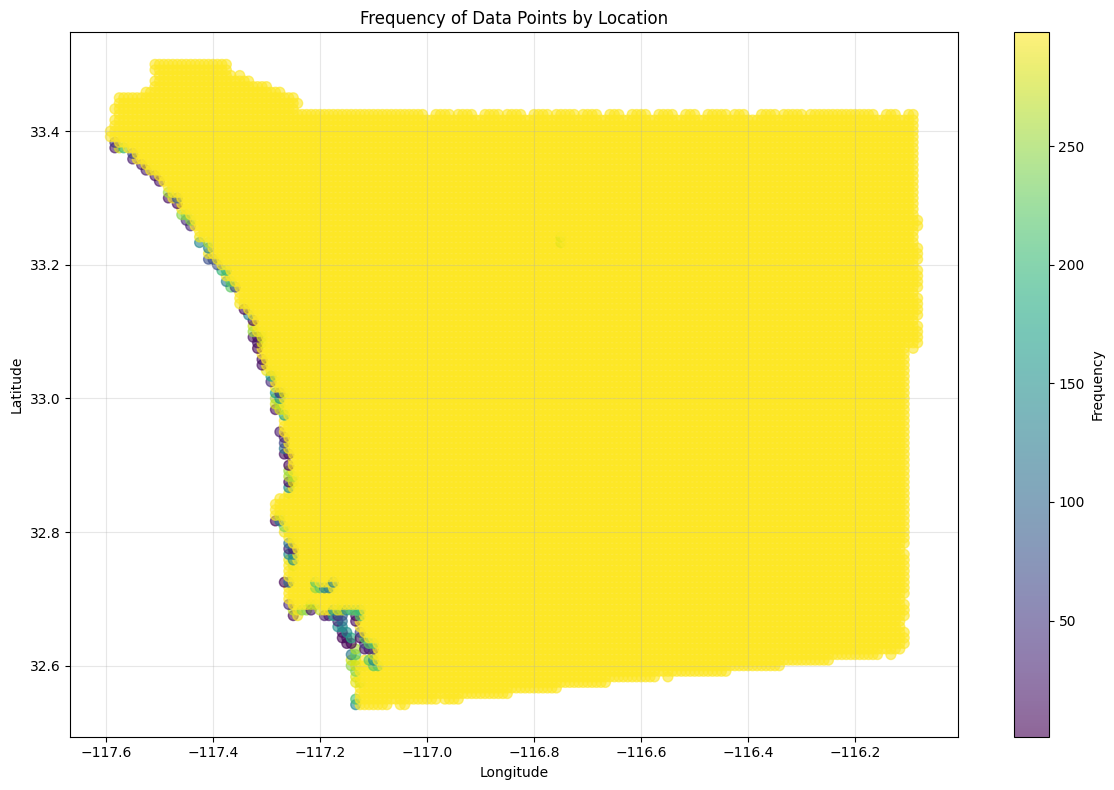

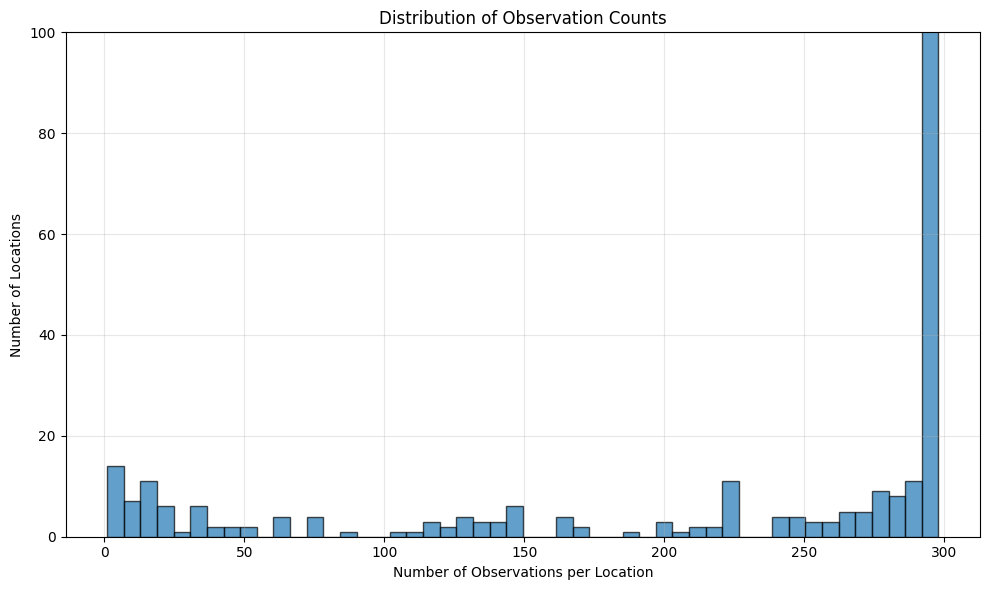

In [14]:
def plot_coord_count(df):
    location_counts = df.groupby(['lat', 'lon']).size().reset_index(name='count')

    print(f"Total unique locations: {len(location_counts)}")
    print(f"Min count: {location_counts['count'].min()}")
    print(f"Max count: {location_counts['count'].max()}")
    print(f"Median count: {location_counts['count'].median():.1f}")

    # Visualization 1: Spatial heatmap
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(location_counts['lon'], location_counts['lat'], 
                        c=location_counts['count'], 
                        cmap='viridis', 
                        s=50, 
                        alpha=0.6)
    plt.colorbar(scatter, label='Frequency')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Frequency of Data Points by Location')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Visualization 2: Histogram of frequencies
    plt.figure(figsize=(10, 6))
    plt.hist(location_counts['count'], bins=50, edgecolor='black', alpha=0.7)
    plt.ylim(0, 100)
    plt.xlabel('Number of Observations per Location')
    plt.ylabel('Number of Locations')
    plt.title('Distribution of Observation Counts')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_coord_count(df)

Total unique locations: 15119
Min count: 298
Max count: 298
Median count: 298.0


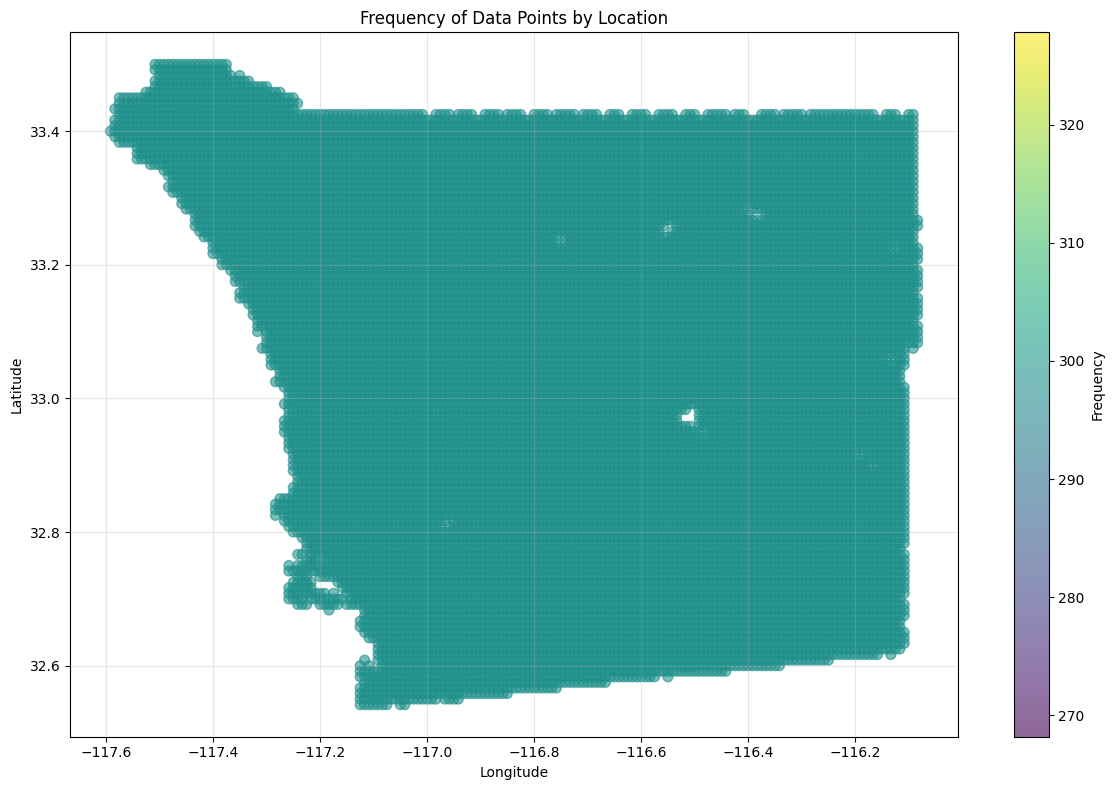

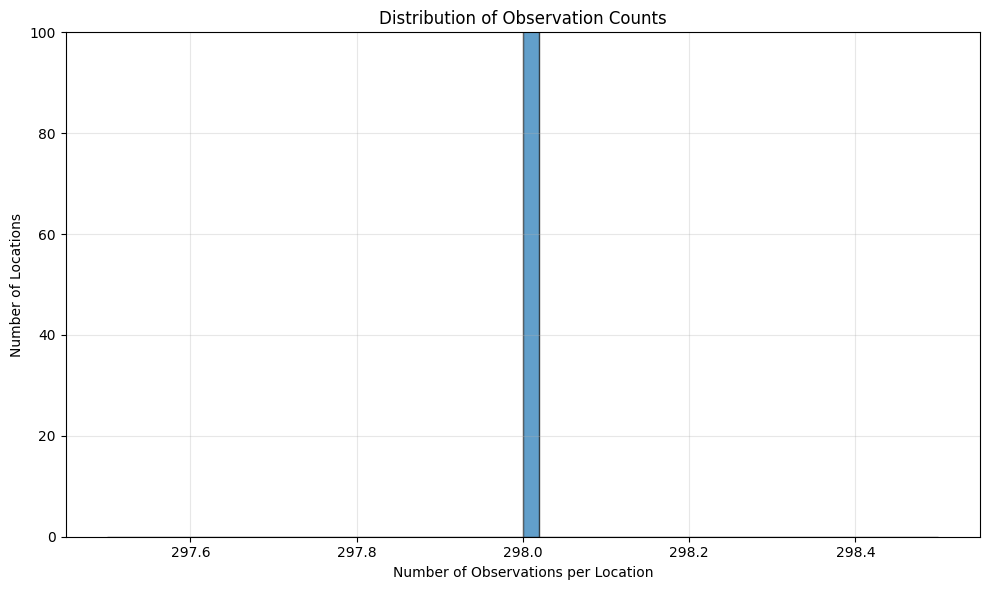

In [15]:
# Keep coordinates that have max count
coord_count = df.groupby(['lat', 'lon']).size().reset_index(name='count').sort_values(by='count', ascending=True)
coord_keep = coord_count[coord_count['count'] == coord_count['count'].max()][['lat', 'lon']].reset_index(drop=True)

df = df.merge(coord_keep, on=['lat', 'lon'], how='right')

plot_coord_count(df)

## Feature Engineering

### Log Transformations

In [16]:
log_variables = ['ppt', 'vpdmax']

for var in log_variables:
    df[f'{var}_log'] = np.log1p(df[var])
    df.drop(columns = [var], inplace = True)

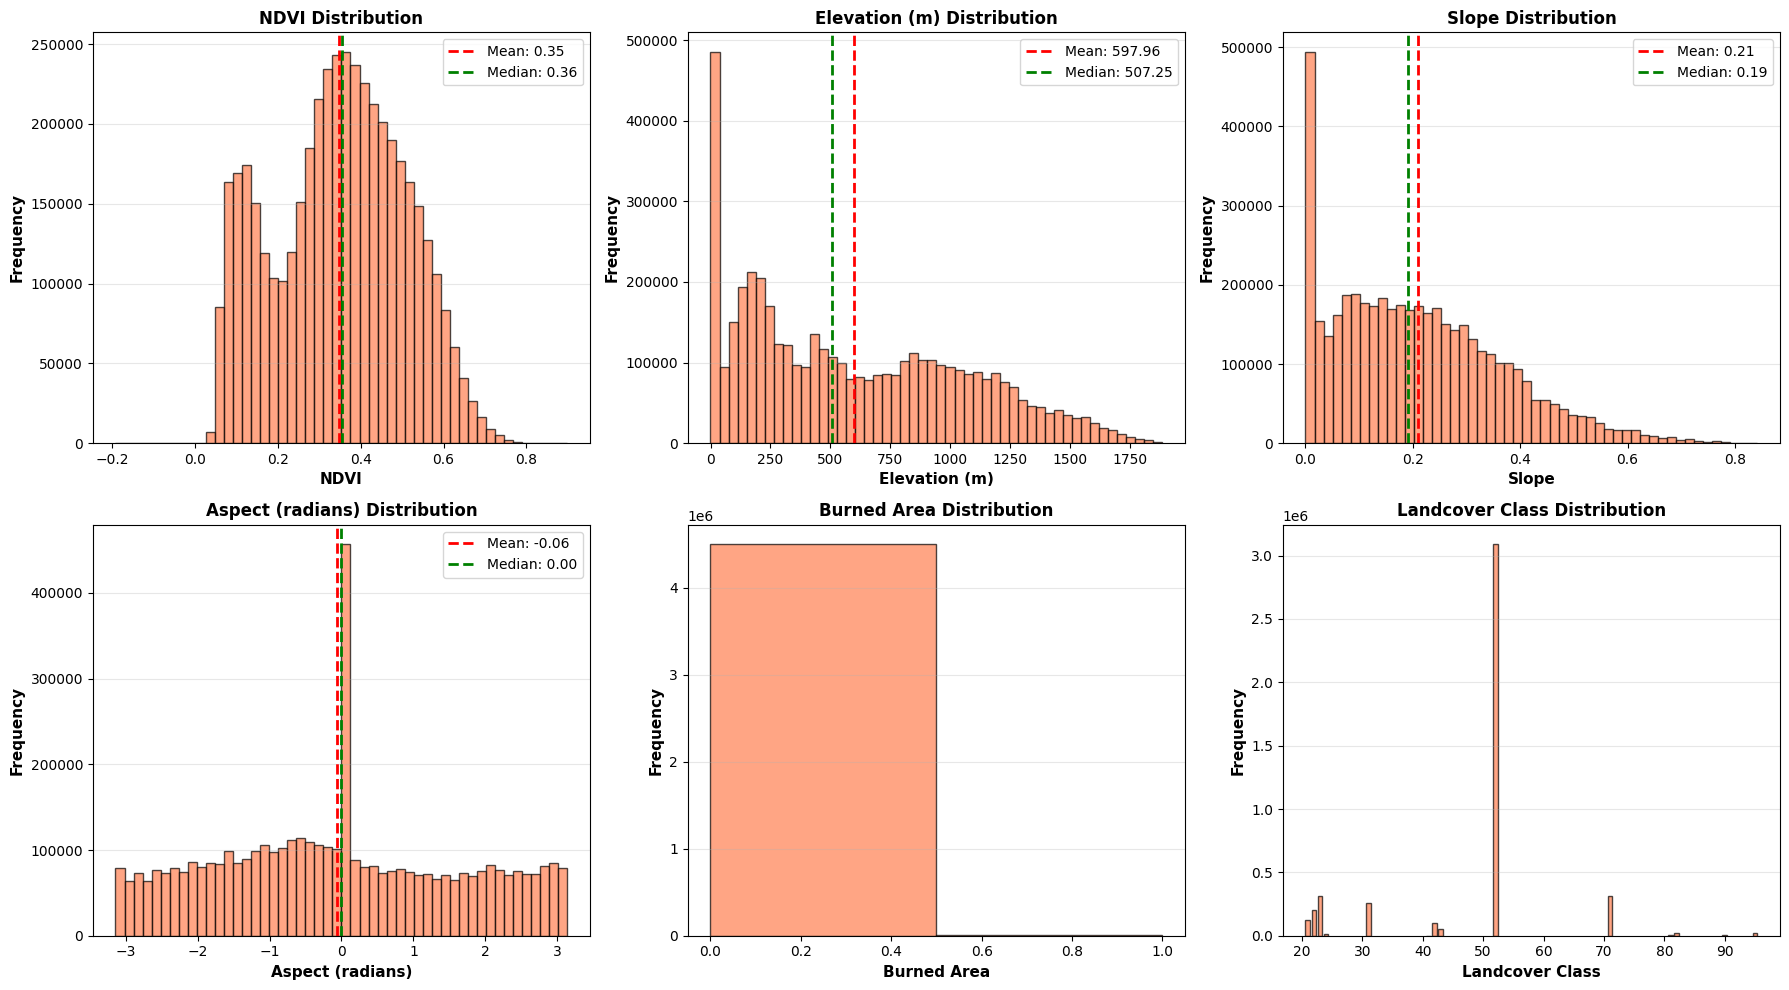

In [17]:
def plot_distributions(df):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    vars_to_plot = [
        ('ndvi', 'NDVI', 50),
        ('elevation', 'Elevation (m)', 50),
        ('slope', 'Slope', 50),
        ('aspect', 'Aspect (radians)', 50),
        ('burned_area', 'Burned Area', 2),
        ('landcover', 'Landcover Class', 20)
    ]

    for idx, (var, label, bins) in enumerate(vars_to_plot):
        data = df[var].dropna()
        
        if var == 'landcover':
            # Bar plot for categorical
            value_counts = data.value_counts().sort_index()
            axes[idx].bar(value_counts.index, value_counts.values, alpha=0.7, color='coral', edgecolor='black')
        else:
            axes[idx].hist(data, bins=bins, alpha=0.7, color='coral', edgecolor='black')
            if var != 'burned_area':  # Skip mean/median for binary
                axes[idx].axvline(data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {data.mean():.2f}')
                axes[idx].axvline(data.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {data.median():.2f}')
        
        axes[idx].set_xlabel(label, fontweight='bold', fontsize=11)
        axes[idx].set_ylabel('Frequency', fontweight='bold', fontsize=11)
        axes[idx].set_title(f'{label} Distribution', fontweight='bold', fontsize=12)
        if var != 'landcover' and var != 'burned_area':
            axes[idx].legend()
        axes[idx].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

plot_distributions(df)

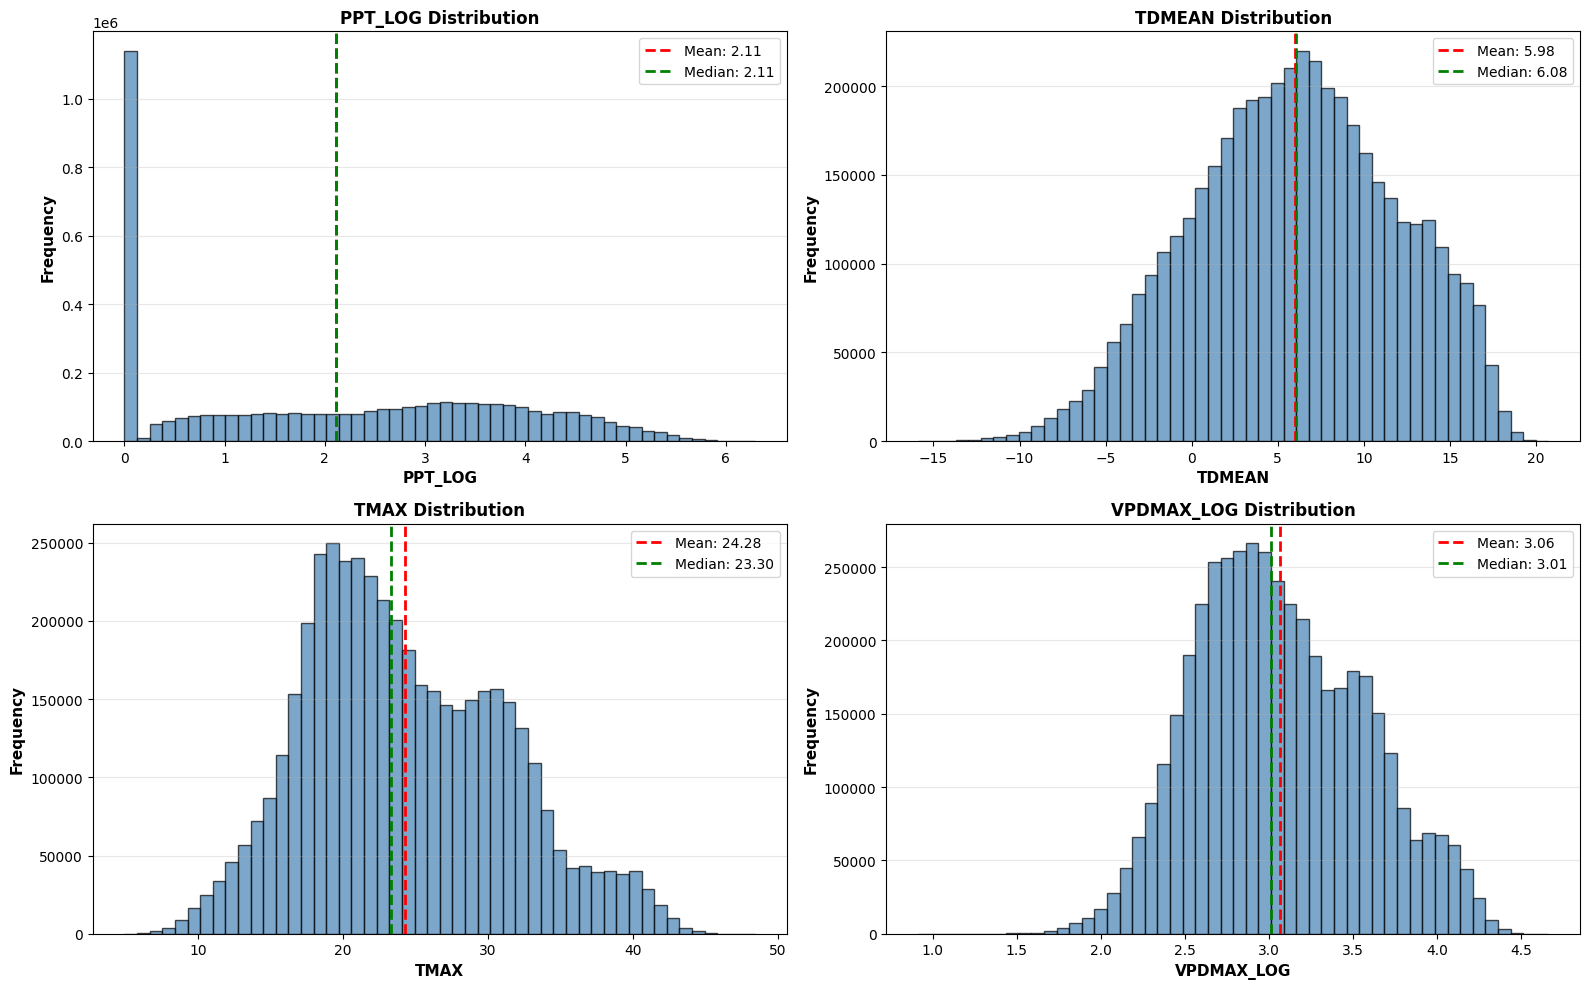

In [18]:
def plot_climate(df):
    climate_vars = ['ppt_log', 'tdmean', 'tmax', 'vpdmax_log']
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.flatten()

    for idx, var in enumerate(climate_vars):
        data = df[var].dropna()
        
        axes[idx].hist(data, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
        axes[idx].axvline(data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {data.mean():.2f}')
        axes[idx].axvline(data.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {data.median():.2f}')
        
        axes[idx].set_xlabel(var.upper(), fontweight='bold', fontsize=11)
        axes[idx].set_ylabel('Frequency', fontweight='bold', fontsize=11)
        axes[idx].set_title(f'{var.upper()} Distribution', fontweight='bold', fontsize=12)
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

plot_climate(df)

### One-Hot Encode Landcover

In [19]:
from sklearn.preprocessing import OneHotEncoder

landcover_class_names = {
    11: 'Open_Water',
    12: 'Perennial_Ice_Snow',
    21: 'Developed_Open_Space',
    22: 'Developed_Low_Intensity',
    23: 'Developed_Medium_Intensity',
    24: 'Developed_High_Intensity',
    31: 'Barren_Land',
    41: 'Deciduous_Forest',
    42: 'Evergreen_Forest',
    43: 'Mixed_Forest',
    51: 'Dwarf_Scrub',
    52: 'Shrub_Scrub',
    71: 'Grassland_Herbaceous',
    72: 'Sedge_Herbaceous',
    73: 'Lichens',
    74: 'Moss',
    81: 'Pasture_Hay',
    82: 'Cultivated_Crops',
    90: 'Woody_Wetlands',
    95: 'Emergent_Herbaceous_Wetlands'
}

all_landcover_classes = np.array([11, 12, 21, 22, 23, 24, 31, 41, 42, 43, 
                                   51, 52, 71, 72, 73, 74, 81, 82, 90, 95])

encoder = OneHotEncoder(
    categories=[all_landcover_classes], 
    handle_unknown='ignore',
    sparse_output=False, 
    dtype=np.int16
)

landcover = df['landcover']
landcover_encoded = encoder.fit_transform(landcover.values.reshape(-1, 1))

column_names = [f'landcover_{landcover_class_names[int(landcover_class)].lower()}' 
                for landcover_class in all_landcover_classes]

df_encoded = pd.concat([
    df, 
    pd.DataFrame(landcover_encoded, columns=column_names)
], axis=1)

df_encoded.drop('landcover', axis=1, inplace=True)

df_encoded['burned_area'] = df_encoded['burned_area'].astype(int)

df_encoded.head()

lat        lon  year  month  tdmean       tmax  burned_area    ndvi  \
0  33.18333 -116.40833  2000      3   3.011  17.820002            0  0.1736   
1  33.18333 -116.40833  2000      4   4.406  24.780001            0  0.1757   
2  33.18333 -116.40833  2000      5   7.045  29.280001            0  0.1546   
3  33.18333 -116.40833  2000      6   9.562  32.980003            0  0.1382   
4  33.18333 -116.40833  2000      7   5.307  35.470001            0  0.1405   

     elevation     slope  ...  landcover_dwarf_scrub  landcover_shrub_scrub  \
0  1742.561168  0.275897  ...                      0                      1   
1  1742.561168  0.275897  ...                      0                      1   
2  1742.561168  0.275897  ...                      0                      1   
3  1742.561168  0.275897  ...                      0                      1   
4  1742.561168  0.275897  ...                      0                      1   

   landcover_grassland_herbaceous  landcover_sedge_herbaceous  \
0                               0                           0   
1                               0                           0   
2                               0                           0   
3                               0                           0   
4                               0                           0   

   landcover_lichens  landcover_moss  landcover_pasture_hay  \
0                  0               0                      0   
1                  0               0                      0   
2                  0               0                      0   
3                  0               0                      0   
4                  0               0                      0   

   landcover_cultivated_crops  landcover_woody_wetlands  \
0                           0                         0   
1                           0                         0   
2                           0                         0   
3                           0                         0   
4                           0                         0   

   landcover_emergent_herbaceous_wetlands  
0                                       0  
1                                       0  
2                                       0  
3                                       0  
4                                       0  

[5 rows x 33 columns]

In [20]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4505462 entries, 0 to 4505461
Data columns (total 33 columns):
 #   Column                                  Dtype  
---  ------                                  -----  
 0   lat                                     float64
 1   lon                                     float64
 2   year                                    int64  
 3   month                                   int64  
 4   tdmean                                  float64
 5   tmax                                    float64
 6   burned_area                             int64  
 7   ndvi                                    float64
 8   elevation                               float64
 9   slope                                   float64
 10  aspect                                  float64
 11  ppt_log                                 float64
 12  vpdmax_log                              float64
 13  landcover_open_water                    int16  
 14  landcover_perennial_ice_snow      

### Multicollinearity

In [21]:
from sklearn.decomposition import PCA

print("Correlation between tmax and vpdmax_log:")
print(f"{df_encoded[['tmax', 'vpdmax_log']].corr().iloc[0, 1]:.3f}")

pca = PCA(n_components=1)

heat_features = df_encoded[['tmax', 'vpdmax_log']].values
heat_pca = pca.fit_transform(heat_features)

df_encoded['tmax_vpdmax_log_pca'] = heat_pca

print(f"\nExplained variance: {pca.explained_variance_ratio_[0]:.3f}")
print(f"Component loadings: tmax={pca.components_[0][0]:.3f}, vpdmax_log={pca.components_[0][1]:.3f}")

df_reduced = df_encoded.drop(['tmax', 'vpdmax_log'], axis=1)

Correlation between tmax and vpdmax_log:
0.923

Explained variance: 0.999
Component loadings: tmax=0.998, vpdmax_log=0.067


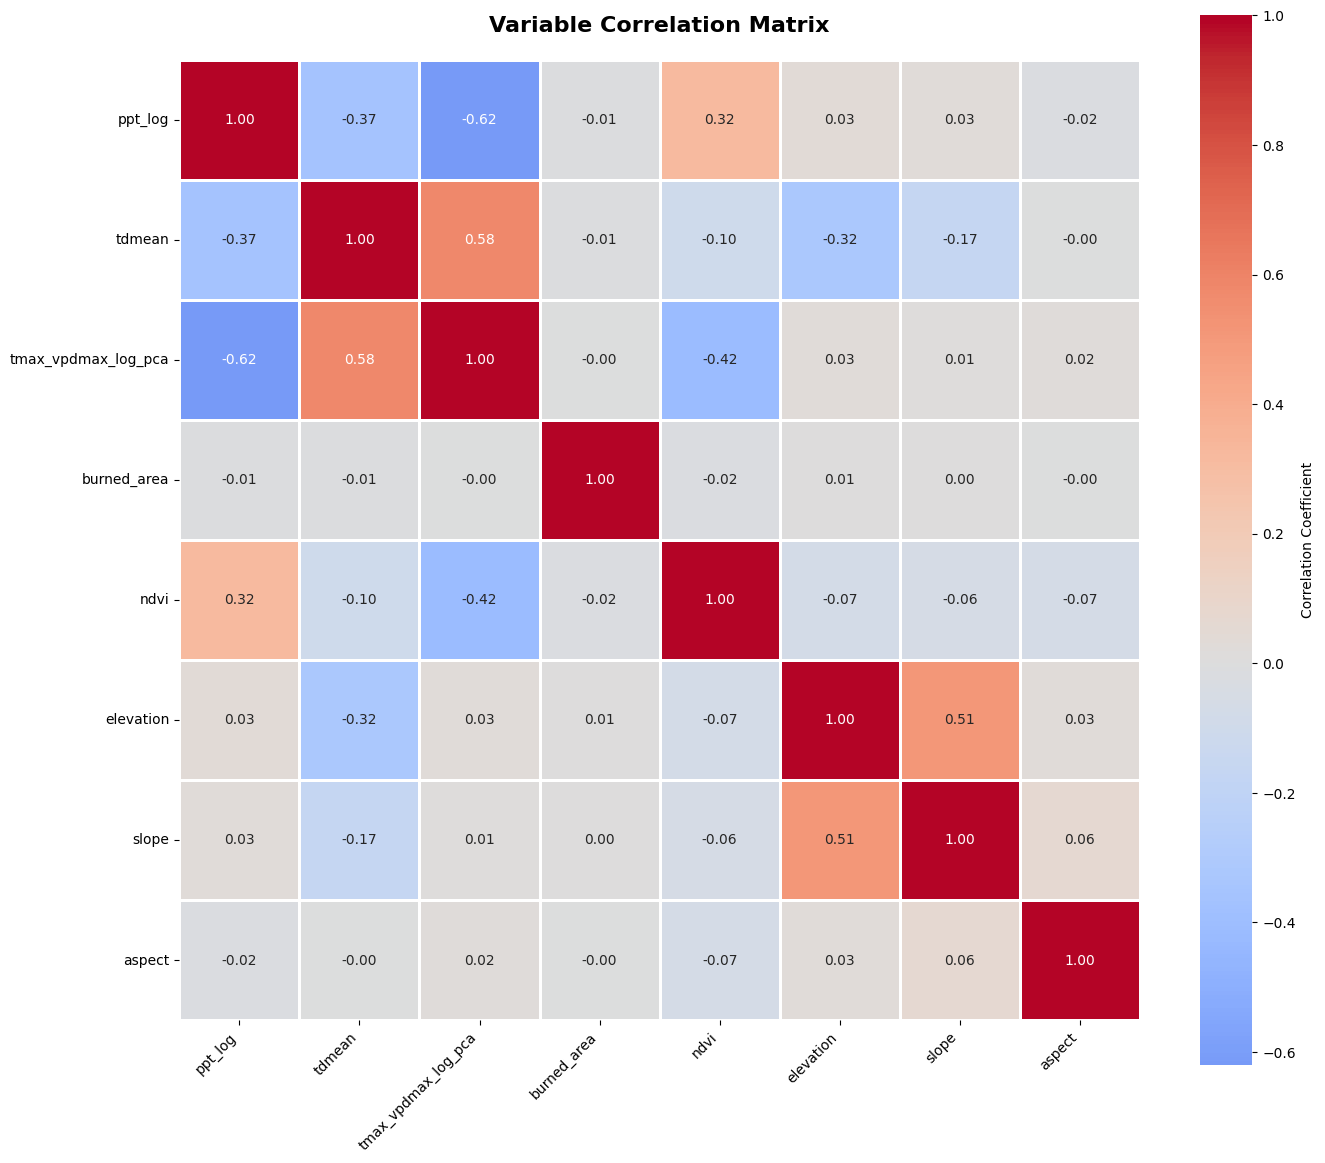

Strong Correlations (|r| > 0.5)
ppt_log         <-> tmax_vpdmax_log_pca: -0.620
tdmean          <-> tmax_vpdmax_log_pca:  0.578
elevation       <-> slope          :  0.507


In [22]:
numeric_cols = ['ppt_log', 'tdmean', 'tmax_vpdmax_log_pca', 'burned_area', 'ndvi', 
                'elevation', 'slope', 'aspect'] # + column_names
corr_matrix = df_reduced[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, ax=ax,
            cbar_kws={'label': 'Correlation Coefficient'})
ax.set_title('Variable Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("Strong Correlations (|r| > 0.5)")
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.5:
            print(f"{corr_matrix.columns[i]:15s} <-> {corr_matrix.columns[j]:15s}: {corr_matrix.iloc[i, j]:6.3f}")

### Dataset Splitting

In [23]:
from sklearn.model_selection import train_test_split

validation_set = df_reduced[(df_reduced['year'] >= 2005) & (df_reduced['year'] <= 2009)]

remaining_data = df_reduced[(df_reduced['year'] < 2005) | (df_reduced['year'] > 2009)]

X = remaining_data.drop('burned_area', axis=1)
y = remaining_data['burned_area']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_validation = validation_set.drop('burned_area', axis=1)
y_validation = validation_set['burned_area']

print(f"Validation set shape: {validation_set.shape}")
print(f"Train set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

print(f"\nValidation years: {[int(yr) for yr in sorted(X_validation['year'].unique())]}")
print(f"Train years:      {[int(yr) for yr in sorted(X_train['year'].unique())]}")
print(f"Test years:       {[int(yr) for yr in sorted(X_test['year'].unique())]}")

Validation set shape: (907140, 32)
Train set shape: (2518825, 31)
Test set shape: (1079497, 31)

Validation years: [2005, 2006, 2007, 2008, 2009]
Train years:      [2000, 2001, 2002, 2003, 2004, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
Test years:       [2000, 2001, 2002, 2003, 2004, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]


### Normalize

In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_validation_scaled = scaler.transform(X_validation)

## Model Training

### Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42, class_weight='balanced')

logreg.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1,
                   random_state=42)

In [26]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score

print("Class distribution:")
print(y_train.value_counts(normalize=True))

y_pred = logreg.predict(X_test_scaled)
y_pred_proba = logreg.predict_proba(X_test_scaled)[:, 1]

print(f"\nTrain accuracy: {logreg.score(X_train_scaled, y_train):.4f}")
print(f"Test accuracy: {logreg.score(X_test_scaled, y_test):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

print(f"\nPR-AUC: {average_precision_score(y_test, y_pred_proba):.4f}")

Class distribution:
burned_area
0    0.998941
1    0.001059
Name: proportion, dtype: float64

Train accuracy: 0.8401
Test accuracy: 0.8400

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.84      0.91   1078366
           1       0.01      0.87      0.01      1131

    accuracy                           0.84   1079497
   macro avg       0.50      0.85      0.46   1079497
weighted avg       1.00      0.84      0.91   1079497


Confusion Matrix:
[[905751 172615]
 [   148    983]]

ROC-AUC Score: 0.9287

PR-AUC: 0.0154


In [27]:
feature_names = X.columns
weights_df = pd.DataFrame({
    'feature': feature_names,
    'weight': logreg.coef_[0]
})

weights_df_sorted = weights_df.sort_values(by='weight', key=lambda x: x.abs(), ascending=False).reset_index(drop=True)

print(weights_df_sorted)

                                   feature    weight
0                                      lon -2.759983
1                                     ndvi -2.043326
2                    landcover_barren_land -1.589709
3                                   tdmean -1.088037
4                                     year -1.072642
5                      tmax_vpdmax_log_pca  1.018766
6               landcover_cultivated_crops -0.926371
7                                elevation  0.879575
8                    landcover_shrub_scrub  0.852605
9       landcover_developed_high_intensity -0.840088
10              landcover_evergreen_forest  0.679686
11    landcover_developed_medium_intensity -0.678556
12                                   month  0.618166
13          landcover_grassland_herbaceous  0.562817
14                                 ppt_log  0.439451
15                  landcover_mixed_forest  0.418917
16       landcover_developed_low_intensity -0.199825
17                                   slope -0.

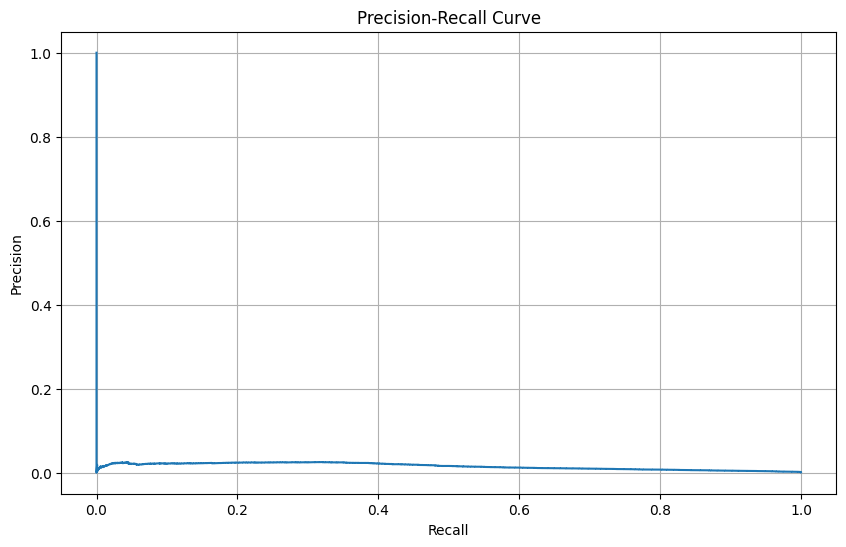

Recall 10%: Precision = 0.022, Threshold = 0.9765
Recall 20%: Precision = 0.024, Threshold = 0.9622
Recall 30%: Precision = 0.025, Threshold = 0.9477


In [28]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

for target_recall in [0.1, 0.2, 0.3]:
    idx = np.argmin(np.abs(recalls[:-1] - target_recall))
    print(f"Recall {target_recall:.0%}: Precision = {precisions[idx]:.3f}, Threshold = {thresholds[idx]:.4f}")

### Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(
    n_estimators=200,          # Number of trees - start with 200 for good performance/speed balance
    max_depth=15,              # Limit tree depth to prevent overfitting
    max_features='sqrt',       # Use sqrt(n_features) for each split - good for classification
    class_weight='balanced_subsample',   # Handle class imbalance (fires are likely rare events)
    random_state=42,           # For reproducibility
    n_jobs=-1,                 # Use all CPU cores
    verbose=1                  # Show progress during training
)

rfc.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 172 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   43.3s finished


RandomForestClassifier(class_weight='balanced_subsample', max_depth=15,
                       n_estimators=200, n_jobs=-1, random_state=42, verbose=1)

In [30]:
y_pred = rfc.predict(X_test_scaled)
y_pred_proba = rfc.predict_proba(X_test_scaled)[:, 1]

print(f"\nTrain accuracy: {rfc.score(X_train_scaled, y_train):.4f}")
print(f"Test accuracy: {rfc.score(X_test_scaled, y_test):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

print(f"\nPR-AUC: {average_precision_score(y_test, y_pred_proba):.4f}")

/Users/gwuwong/Documents/ucsd/DSC/DSC_180A/CotalityQ1Capstone/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=14)]: Done 172 tasks      | elapsed:    0.2s
[Parallel(n_jobs=14)]: Done 200 out of 200 | elapsed:    0.3s finished
/Users/gwuwong/Documents/ucsd/DSC/DSC_180A/CotalityQ1Capstone/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=14)]: Done 172 tasks      | elapsed:    0.2s
[Parallel(n_jobs=14)]: Done 200 out o


Train accuracy: 0.9989


[Parallel(n_jobs=14)]: Done 172 tasks      | elapsed:    0.2s
[Parallel(n_jobs=14)]: Done 200 out of 200 | elapsed:    0.3s finished
/Users/gwuwong/Documents/ucsd/DSC/DSC_180A/CotalityQ1Capstone/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/gwuwong/Documents/ucsd/DSC/DSC_180A/CotalityQ1Capstone/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/gwuwong/Documents/ucsd/DSC/DSC_180A/CotalityQ1Capstone/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divis

Test accuracy: 0.9990

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1078366
           1       0.00      0.00      0.00      1131

    accuracy                           1.00   1079497
   macro avg       0.50      0.50      0.50   1079497
weighted avg       1.00      1.00      1.00   1079497


Confusion Matrix:
[[1078366       0]
 [   1131       0]]

ROC-AUC Score: 0.5325

PR-AUC: 0.0061


### Random Forest Cross Validation

In [31]:
# from sklearn.model_selection import RandomizedSearchCV

# param_dist = {
#     'n_estimators': [200, 300, 500],
#     'max_depth': [10, 15, 20, 30, None],
#     'max_features': ['sqrt', 'log2'],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     # 'bootstrap': [True, False]
# }

# rfc = RandomForestClassifier(class_weight='balanced_subsample', random_state=42, n_jobs=-1)

# random_search = RandomizedSearchCV(
#     estimator=rfc,
#     param_distributions=param_dist,
#     n_iter=50,
#     cv=5,
#     verbose=2,
#     random_state=42,
#     n_jobs=-1,
#     scoring='accuracy' # You can change this to 'roc_auc' or 'accuracy' if preferred
# )

# # Fit the random search model
# random_search.fit(X_train, y_train)

# # Output the best parameters and score
# print(f"Best Parameters: {random_search.best_params_}")
# print(f"Best F1 Score: {random_search.best_score_:.4f}")

# # You can access the best estimator directly
# best_rfc = random_search.best_estimator_
# print("\nBest estimator object is available as 'best_rfc' variable.")

### SVM

In [32]:
from sklearn.svm import LinearSVC

svm = LinearSVC(random_state=42, verbose=1, dual=False, max_iter=1000)

svm.fit(X_train_scaled, y_train)

[LibLinear]iter  1 act 2.508e+06 pre 2.508e+06 delta 9.979e-01 f 2.519e+06 |g| 5.027e+06 CG   1
iter  2 act 3.994e+01 pre 3.106e+01 delta 9.979e-01 f 1.063e+04 |g| 7.524e+03 CG   7
iter  3 act 2.883e+01 pre 2.157e+01 delta 9.979e-01 f 1.059e+04 |g| 4.408e+03 CG   8
iter  4 act 2.007e+01 pre 1.550e+01 delta 9.979e-01 f 1.056e+04 |g| 3.340e+03 CG   9
iter  5 act 8.386e+00 pre 6.905e+00 delta 9.979e-01 f 1.054e+04 |g| 2.158e+03 CG   9
iter  6 act 1.536e+00 pre 1.350e+00 delta 9.979e-01 f 1.053e+04 |g| 9.529e+02 CG  10
iter  7 act 1.671e-01 pre 1.385e-01 delta 9.979e-01 f 1.053e+04 |g| 2.168e+02 CG  12
iter  8 act 6.683e-02 pre 5.504e-02 delta 9.979e-01 f 1.053e+04 |g| 4.233e+01 CG  19
iter  9 act 1.812e-02 pre 1.462e-02 delta 9.979e-01 f 1.053e+04 |g| 9.984e+00 CG  23
iter 10 act 6.888e-03 pre 5.240e-03 delta 9.979e-01 f 1.053e+04 |g| 3.266e+00 CG  25
iter 11 act 2.116e-03 pre 1.840e-03 delta 9.979e-01 f 1.053e+04 |g| 1.326e+00 CG  25
iter 12 act 2.267e-04 pre 2.126e-04 delta 9.979e-01 f 

LinearSVC(dual=False, random_state=42, verbose=1)

In [33]:
y_pred = svm.predict(X_test_scaled)

y_scores = svm.decision_function(X_test_scaled)

print(f"\nTrain accuracy: {svm.score(X_train_scaled, y_train):.4f}")
print(f"Test accuracy:  {svm.score(X_test_scaled, y_test):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_scores):.4f}")
print(f"\nPR-AUC:        {average_precision_score(y_test, y_scores):.4f}")


Train accuracy: 0.9989
Test accuracy:  0.9990

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1078366
           1       0.00      0.00      0.00      1131

    accuracy                           1.00   1079497
   macro avg       0.50      0.50      0.50   1079497
weighted avg       1.00      1.00      1.00   1079497


Confusion Matrix:
[[1078366       0]
 [   1131       0]]


/Users/gwuwong/Documents/ucsd/DSC/DSC_180A/CotalityQ1Capstone/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/gwuwong/Documents/ucsd/DSC/DSC_180A/CotalityQ1Capstone/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/gwuwong/Documents/ucsd/DSC/DSC_180A/CotalityQ1Capstone/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.




ROC-AUC Score: 0.9114

PR-AUC:        0.0468


## Model Validation

In [34]:
# Validate Logistic Regression

y_val_pred = logreg.predict(X_validation_scaled)
y_val_pred_proba = logreg.predict_proba(X_validation_scaled)[:, 1]

print(f"\nTrain accuracy: {logreg.score(X_train_scaled, y_train):.4f}")
print(f"Test accuracy: {logreg.score(X_test_scaled, y_test):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

print(f"\nPR-AUC: {average_precision_score(y_test, y_pred_proba):.4f}")


Train accuracy: 0.8401
Test accuracy: 0.8400

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1078366
           1       0.00      0.00      0.00      1131

    accuracy                           1.00   1079497
   macro avg       0.50      0.50      0.50   1079497
weighted avg       1.00      1.00      1.00   1079497


Confusion Matrix:
[[1078366       0]
 [   1131       0]]

ROC-AUC Score: 0.5325

PR-AUC: 0.0061


/Users/gwuwong/Documents/ucsd/DSC/DSC_180A/CotalityQ1Capstone/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/gwuwong/Documents/ucsd/DSC/DSC_180A/CotalityQ1Capstone/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/gwuwong/Documents/ucsd/DSC/DSC_180A/CotalityQ1Capstone/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

